In [1]:
import os

In [2]:
computation = 'cloud'

In [3]:
if computation == 'cloud' :
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = '/content/drive/MyDrive/uco_fraud_detector/data/transaction_fraud'
  model_save_path = '/content/drive/MyDrive/uco_fraud_detector/models'
  customer_fr_path = '/content/drive/MyDrive/uco_fraud_detector/models/customer_fr_database'
  merchant_fr_path = '/content/drive/MyDrive/uco_fraud_detector/models/merchant_fr_database'
  globalmodel_path = '/content/drive/MyDrive/uco_fraud_detector/models/globalmodel'
else :
  data_path = '../data/transaction_fraud'
  model_save_path = '../models'
  customer_fr_path = '../models/customer_fr_database'
  merchant_fr_path = '../models/merchant_fr_database'
  globalmodel_path = '../models/globalmodel'

print("searching for data path" , "found" if os.path.exists(data_path) else "not found")
print(os.listdir(data_path))

Mounted at /content/drive
searching for data path found
['bs140513_032310.csv', 'bsNET140513_032310.csv']


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Multiply
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

In [5]:
np.random.seed(21)
tf.random.set_seed(21)

In [6]:
data_file = os.path.join(data_path, 'bs140513_032310.csv')

In [7]:
df = pd.read_csv(data_file)

In [8]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPUs detected: {physical_devices}")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU detected, using CPU")


GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
data_preprocess_path = '/content/drive/MyDrive/uco_fraud_detector/data/data_preprocess'
with open(data_preprocess_path, 'rb') as f :
  data_preprocess = pickle.load(f)

In [10]:
df = df.replace("'" , "" , regex=True)
df = df.drop(['zipcodeOri' , 'zipMerchant'] , axis = 1)
df['account_frequency'] = df['customer'].apply(lambda x: data_preprocess['customer_frequency_rating_encoder'][x])
df['merchant_frequency'] = df['merchant'].apply(lambda x: data_preprocess['merchant_frequency_rating_encoder'][x])
df = df.rename(columns={'customer': 'account_id', 'merchant': 'merchant_id', 'step': 'time_delta'})
df = df.sort_values(['account_id', 'time_delta'])
df = df.reset_index(drop=True)
for c in data_preprocess['CATEGORICAL_COLS'] :
  df[c] = data_preprocess[c + '_label_encoder'].transform(df[c])
df[data_preprocess['NUMERICAL_COLS']] = data_preprocess['numerical_scaler'].transform(df[data_preprocess['NUMERICAL_COLS']])
df.head()

,time_delta,account_id,age,gender,merchant_id,category,amount,fraud,account_frequency,merchant_frequency
0,-1.272914,C1000148617,5,2,22,9,0.951322,0,-0.918953,-2.237926
1,-1.116216,C1000148617,5,2,15,10,-0.190302,0,-0.918953,-2.241786
2,-1.037867,C1000148617,5,2,22,9,0.164178,0,-0.918953,-2.237926
3,-1.018280,C1000148617,5,2,42,11,-0.207806,0,-0.918953,-2.233031
4,-0.998692,C1000148617,5,2,18,12,0.085544,0,-0.918953,0.765246


In [11]:
# data_preprocess = {
#     'NUMERICAL_COLS' : NUMERICAL_COLS,
#     'CATEGORICAL_COLS' : CATEGORICAL_COLS,
#     'TARGET_COL' : TARGET_COL,
#     'numerical_scaler' : scaler,
#     'age_label_encoder' : age_label_encoder,
#     'gender_label_encoder' : gender_label_encoder,
#     'merchant_id_label_encoder' : merchant_label_encoder,
#     'category_label_encoder' : category_label_encoder,
#     'customer_frequency_rating_encoder' : customer_frequency_rating_encoder,
#     'merchant_frequency_rating_encoder' : merchant_frequency_rating_encoder
# }
# saved_data_path = '/content/drive/MyDrive/uco_fraud_detector/data/data_preprocess'
# with open(saved_data_path, 'wb') as f:
#     pickle.dump(data_preprocess, f)

In [12]:
N = 100
TOTAL_SEQUENCE_LENGTH = N + 1

# Embedding dimensions
EMBEDDING_DIM_AGE = df['age'].nunique()
EMBEDDING_DIM_GENDER = df['gender'].nunique()
EMBEDDING_DIM_MERCHANT = min(df['merchant_id'].nunique(), 100)
EMBEDDING_DIM_CATEGORY = df['category'].nunique()


In [13]:
import numpy as np

def create_sequences_no_fraud_optimized(df, seq_length, numerical_cols, categorical_cols, target_col, N=100):
    num_features = len(numerical_cols) + len(categorical_cols)
    total_transactions = len(df)
    sequences = np.zeros((total_transactions, seq_length, num_features), dtype=np.float32)
    relevance_scores = np.zeros((total_transactions, seq_length), dtype=np.float32)
    targets = df[target_col].values

    # Precompute account-level data
    account_data = df.groupby('account_id').apply(
        lambda x: (x[numerical_cols + categorical_cols].values, x[target_col].values, x['time_delta'].values)
    ).to_dict()

    for idx in range(total_transactions):
        account_id = df.iloc[idx]['account_id']
        current_transaction = df.iloc[idx][numerical_cols + categorical_cols].values.reshape(1, -1)
        current_time = df.iloc[idx]['time_delta']
        current_fraud = df.iloc[idx][target_col]

        # Get all transactions for the account
        all_features, all_frauds, all_times = account_data[account_id]
        valid_mask = (all_frauds == 0) & (all_times <= current_time)
        valid_features = all_features[valid_mask]
        valid_times = all_times[valid_mask]

        if len(valid_features) == 0:
            seq = np.pad(current_transaction, ((0, seq_length - 1), (0, 0)), mode='constant')
            relevance = np.pad(np.array([1.0]), (0, seq_length - 1), mode='constant')
        else:
            # Vectorized relevance scoring
            cat_sim = np.mean(valid_features[:, len(numerical_cols):] == current_transaction[0, len(numerical_cols):], axis=1)
            num_diff = np.mean(np.abs(valid_features[:, :len(numerical_cols)] - current_transaction[0, :len(numerical_cols)]), axis=1)
            max_num_diff = np.max(np.abs(all_features[:, :len(numerical_cols)])) + 1e-5
            similarity = 0.7 * cat_sim + 0.3 * (1 - num_diff / max_num_diff)

            time_diff = np.abs(valid_times - current_time)
            decay = np.exp(-0.01 * time_diff)

            account_mean = np.mean(valid_features[:, numerical_cols.index('amount')])
            account_std = np.std(valid_features[:, numerical_cols.index('amount')])
            anomaly = (valid_features[:, numerical_cols.index('amount')] > (account_mean + 2 * account_std)).astype(float)

            relevance = 0.5 * similarity + 0.3 * decay + 0.2 * anomaly

            # Select top N
            top_indices = np.argsort(relevance)[-min(N, len(relevance)):] if len(relevance) > 0 else []
            valid_transactions = valid_features[top_indices] if len(top_indices) > 0 else np.zeros((0, num_features))
            seq_relevance = np.concatenate([np.array([1.0]), relevance[top_indices][::-1]]) if len(top_indices) > 0 else np.array([1.0])

            # Build sequence
            seq = np.concatenate([current_transaction, valid_transactions[::-1]], axis=0) if len(valid_transactions) > 0 else current_transaction
            if len(seq) < seq_length:
                padding_len = seq_length - len(seq)
                seq = np.pad(seq, ((0, padding_len), (0, 0)), mode='constant')
                seq_relevance = np.pad(seq_relevance, (0, padding_len), mode='constant')
            elif len(seq) > seq_length:
                seq = seq[:seq_length]
                seq_relevance = seq_relevance[:seq_length]

        sequences[idx] = seq
        relevance_scores[idx] = seq_relevance
        targets[idx] = current_fraud

        progress = (idx + 1) / total_transactions * 100
        if progress % 10 == 0:
          print(f"Progress: {progress:.2f}%", end='\r')
    return sequences, relevance_scores, targets


In [14]:
# sequences, relevance_scores, targets = create_sequences_no_fraud_optimized(df,
#                                                                       TOTAL_SEQUENCE_LENGTH,
#                                                                       data_preprocess['NUMERICAL_COLS'],
#                                                                       data_preprocess['CATEGORICAL_COLS'],
#                                                                       data_preprocess['TARGET_COL'])
# print(f"Sequences shape: {sequences.shape}, Relevance Scores shape: {relevance_scores.shape}")

In [15]:
# import pickle
# relevance_seq_data = {
#     'sequences': sequences,
#     'relevance_scores': relevance_scores,
#     'targets': targets
# }
# data_save_path = '/content/drive/MyDrive/uco_fraud_detector/data/relevance_seq_data_n100_valid_only'
# with open(data_save_path, 'wb') as f:
#     pickle.dump(relevance_seq_data, f)

In [16]:
import pickle
data_save_path = '/content/drive/MyDrive/uco_fraud_detector/data/relevance_seq_data_n100_valid_only'
with open(data_save_path, 'rb') as f:
    relevance_seq_data = pickle.load(f)
sequences = relevance_seq_data['sequences']
relevance_scores = relevance_seq_data['relevance_scores']
targets = relevance_seq_data['targets']

In [17]:
assert sequences.shape == (len(df), TOTAL_SEQUENCE_LENGTH, len(data_preprocess['NUMERICAL_COLS']) + len(data_preprocess['CATEGORICAL_COLS'])), \
    f"Invalid sequences shape: {sequences.shape}"
assert targets.shape == (len(df),), f"Invalid targets shape: {targets.shape}"

In [18]:
n_samples = len(sequences)
indices = np.arange(n_samples)
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, stratify=targets, random_state=21
)

X_train = sequences[train_indices]
X_test = sequences[test_indices]
y_train = targets[train_indices]
y_test = targets[test_indices]
relevance_train = relevance_scores[train_indices]
relevance_test = relevance_scores[test_indices]

print(f"Training sequences: {X_train.shape[0]}, Test sequences: {X_test.shape[0]}")
print(f"Training fraud proportion: {np.mean(y_train):.4f}, Test fraud proportion: {np.mean(y_test):.4f}")

Training sequences: 475714, Test sequences: 118929
Training fraud proportion: 0.0121, Test fraud proportion: 0.0121


In [19]:
train_num_seq = X_train[:, :, :len(data_preprocess['NUMERICAL_COLS'])]
train_cat_seq = X_train[:, :, len(data_preprocess['NUMERICAL_COLS']):].astype(np.int32)
test_num_seq = X_test[:, :, :len(data_preprocess['NUMERICAL_COLS'])]
test_cat_seq = X_test[:, :, len(data_preprocess['NUMERICAL_COLS']):].astype(np.int32)

X_train = {
    'numerical_input': train_num_seq,
    'age_input': train_cat_seq[:, :, 0],
    'gender_input': train_cat_seq[:, :, 1],
    'merchant_input': train_cat_seq[:, :, 2],
    'category_input': train_cat_seq[:, :, 3],
    'relevance_input': relevance_train
}
X_test = {
    'numerical_input': test_num_seq,
    'age_input': test_cat_seq[:, :, 0],
    'gender_input': test_cat_seq[:, :, 1],
    'merchant_input': test_cat_seq[:, :, 2],
    'category_input': test_cat_seq[:, :, 3],
    'relevance_input': relevance_test
}

In [20]:
num_samples_train = X_train['numerical_input'].shape[0]
num_samples_test = X_test['numerical_input'].shape[0]
for key in X_train:
    assert X_train[key].shape[0] == num_samples_train, f"Mismatched train shape for {key}: {X_train[key].shape}"
    assert X_train[key].shape[1] == TOTAL_SEQUENCE_LENGTH, f"Invalid sequence length for {key}: {X_train[key].shape}"
for key in X_test:
    assert X_test[key].shape[0] == num_samples_test, f"Mismatched test shape for {key}: {X_test[key].shape}"
    assert X_test[key].shape[1] == TOTAL_SEQUENCE_LENGTH, f"Invalid sequence length for {key}: {X_test[key].shape}"
print("Input shapes validated successfully")

Input shapes validated successfully


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def TransformerBlock(num_heads, embed_dim, dropout_rate=0.1):
    inputs = layers.Input(shape=(None, embed_dim))
    attention_output = layers.MultiHeadAttention(key_dim=embed_dim, num_heads=num_heads)(inputs, inputs)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    ffn_output = layers.Dense(embed_dim, activation="relu")(out1)
    ffn_output = layers.Dense(embed_dim)(ffn_output)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    return Model(inputs, layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output))

@tf.keras.utils.register_keras_serializable()
class ExpandDims(layers.Layer):
    def __init__(self, **kwargs):
        super(ExpandDims, self).__init__(**kwargs)
    def call(self, inputs):
        return tf.expand_dims(inputs, axis=-1)
    def get_config(self):
        config = super(ExpandDims, self).get_config()
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

def build_transformer_model(seq_length, num_numerical, embed_dims, dropout_rate=0.1):
    # Inputs (removed mask_input)
    numerical_input = layers.Input(shape=(seq_length, num_numerical), name='numerical_input', dtype=tf.float32)
    age_input = layers.Input(shape=(seq_length,), name='age_input', dtype=tf.int32)
    gender_input = layers.Input(shape=(seq_length,), name='gender_input', dtype=tf.int32)
    merchant_input = layers.Input(shape=(seq_length,), name='merchant_input', dtype=tf.int32)
    category_input = layers.Input(shape=(seq_length,), name='category_input', dtype=tf.int32)
    relevance_input = layers.Input(shape=(seq_length,), name='relevance_input', dtype=tf.float32)

    # Embedding layers for categorical inputs
    age_embed = layers.Embedding(embed_dims['age'], 16)(age_input)
    gender_embed = layers.Embedding(embed_dims['gender'], 8)(gender_input)
    merchant_embed = layers.Embedding(embed_dims['merchant'], 32)(merchant_input)
    category_embed = layers.Embedding(embed_dims['category'], 16)(category_input)

    # Combine numerical and categorical embeddings
    cat_combined = layers.Concatenate(axis=-1)([age_embed, gender_embed, merchant_embed, category_embed])
    total_input = layers.Concatenate(axis=-1)([numerical_input, cat_combined])

    # Apply relevance weighting
    relevance_expanded = ExpandDims()(relevance_input)
    weighted_input = layers.Multiply()([total_input, relevance_expanded])

    # Transformer blocks
    x = TransformerBlock(num_heads=4, embed_dim=total_input.shape[-1])(weighted_input)
    x = TransformerBlock(num_heads=4, embed_dim=total_input.shape[-1])(x)

    # Final layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    fraud_prediction = layers.Dense(1, activation="sigmoid", name="fraud_prediction")(x)

    # Build model
    model = Model(inputs=[numerical_input, age_input, gender_input, merchant_input, category_input, relevance_input],
                  outputs=fraud_prediction)

    return model

In [22]:
embed_dims = {'age': EMBEDDING_DIM_AGE, 'gender': EMBEDDING_DIM_GENDER, 'merchant': EMBEDDING_DIM_MERCHANT, 'category': EMBEDDING_DIM_CATEGORY}
model = build_transformer_model(TOTAL_SEQUENCE_LENGTH, len(data_preprocess['NUMERICAL_COLS']), embed_dims)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.AUC(),
                       'precision',
                       'recall'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ age_input           │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_input        │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merchant_input      │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 101, 16)   │        128 │ age_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 101, 8)    │         32 │ gender_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 101, 32)   │      1,600 │ merchant_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 101, 16)   │        240 │ category_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 101, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 101, 72)   │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0… │
│                     │                   │            │ embedding_2[0][0… │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relevance_input     │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 101, 76)   │          0 │ numerical_input[… │
│ (Concatenate)       │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims         │ (None, 101, 1)    │          0 │ relevance_input[… │
│ (ExpandDims)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 101, 76)   │          0 │ concatenate_1[0]… │
│                     │                   │            │ expand_dims[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 101, 76)   │    105,412 │ multiply[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 101, 76)   │    105,412 │ functional[0][0]  │
│ (Functional)        │                   │            │                 

 Total params: 222,809 (870.35 KB)

 Trainable params: 222,809 (870.35 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
plot_model(model, to_file='relevance_transformer_model.png', show_shapes=True, show_layer_names=True)
print('Model plot saved as relevance_transformer_model.png')

Model plot saved as relevance_transformer_model.png


In [24]:
BATCH_SIZE = 32
y_train_reshaped = y_train[:, np.newaxis].astype(np.float32)
y_test_reshaped = y_test[:, np.newaxis].astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'numerical_input': tf.cast(X_train['numerical_input'], tf.float32),
        'age_input': tf.cast(X_train['age_input'], tf.int32),
        'gender_input': tf.cast(X_train['gender_input'], tf.int32),
        'merchant_input': tf.cast(X_train['merchant_input'], tf.int32),
        'category_input': tf.cast(X_train['category_input'], tf.int32),
        'relevance_input': tf.cast(X_train['relevance_input'], tf.float32)
    },
    y_train_reshaped
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'numerical_input': tf.cast(X_test['numerical_input'], tf.float32),
        'age_input': tf.cast(X_test['age_input'], tf.int32),
        'gender_input': tf.cast(X_test['gender_input'], tf.int32),
        'merchant_input': tf.cast(X_test['merchant_input'], tf.int32),
        'category_input': tf.cast(X_test['category_input'], tf.int32),
        'relevance_input': tf.cast(X_test['relevance_input'], tf.float32)
    },
    y_test_reshaped
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score
@tf.keras.utils.register_keras_serializable()
class MetricsCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, save_path, **kwargs):
        super(MetricsCallback, self).__init__(**kwargs)
        self.validation_data = validation_data
        self.save_path = save_path
        self.best_f1 = -float('inf')

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred_prob = self.model.predict(X_val, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        f1 = f1_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_prob)
        print(f" - val_f1_score: {f1:.4f}, val_precision: {precision:.4f}, val_recall: {recall:.4f}, val_roc_auc: {roc_auc:.4f}")

        if f1 > self.best_f1:
            self.best_f1 = f1
            self.model.save(self.save_path, overwrite=True)
            print(f"Saved model with best val_f1_score: {f1:.4f} at {self.save_path}")

    def get_config(self):
        config = super(MetricsCallback, self).get_config()
        config.update({
            'save_path': self.save_path
        })
        return config


In [26]:
best_model_path = os.path.join(model_save_path, 'best_relevance_transformer_n100_model_valid_only.keras')
callbacks = [
    MetricsCallback(validation_data=(X_test, y_test), save_path=best_model_path),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]


In [27]:
history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=test_dataset,
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/50
14867/14867 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9935 - auc: 0.9637 - loss: 0.0223 - precision: 0.8205 - recall: 0.6066 - val_f1_score: 0.8482, val_precision: 0.9162, val_recall: 0.7896, val_roc_auc: 0.9978
Saved model with best val_f1_score: 0.8482 at /content/drive/MyDrive/uco_fraud_detector/models/best_relevance_transformer_n100_model_valid_only.keras
14867/14867 ━━━━━━━━━━━━━━━━━━━━ 199s 12ms/step - accuracy: 0.9935 - auc: 0.9637 - loss: 0.0223 - precision: 0.8205 - recall: 0.6066 - val_accuracy: 0.9966 - val_auc: 0.9904 - val_loss: 0.0104 - val_precision: 0.9162 - val_recall: 0.7896
Epoch 2/50
14867/14867 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9965 - auc: 0.9919 - loss: 0.0112 - precision: 0.9062 - recall: 0.7963 - val_f1_score: 0.8626, val_precision: 0.9273, val_recall: 0.8063, val_roc_auc: 0.9984
Saved model with best val_f1_score: 0.8626 at /content/drive/MyDrive/uco_fraud_detector/models/best_relevance_transformer_n100_model_valid_only.keras
14867

In [28]:
best_model_path = os.path.join(model_save_path, 'best_relevance_transformer_n100_model_valid_only.keras')
with keras.utils.custom_object_scope({'TransformerBlock': TransformerBlock, 'ExpandDims': ExpandDims}):
    model = keras.models.load_model(best_model_path)

In [29]:
result = model.evaluate(test_dataset, verbose=0 , return_dict = True)
print('test resulf \n',result)

test resulf 
 {'accuracy': 0.9974186420440674, 'auc': 0.9966536164283752, 'loss': 0.00761162955313921, 'precision': 0.9388071298599243, 'recall': 0.8416666388511658}


3717/3717 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117489
           1       0.94      0.84      0.89      1440

    accuracy                           1.00    118929
   macro avg       0.97      0.92      0.94    118929
weighted avg       1.00      1.00      1.00    118929



<Axes: >

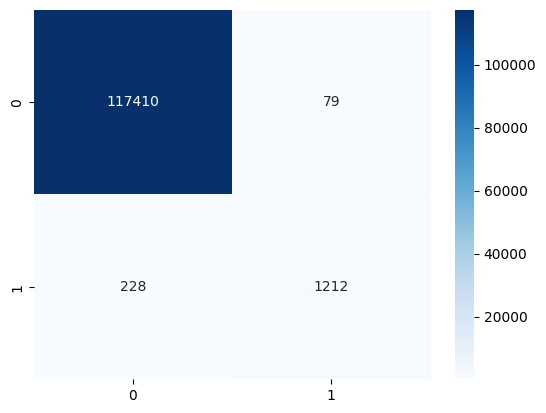

In [30]:
# Compute final F1-score
y_pred_prob = model.predict(test_dataset, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
print(classification_report(y_test , y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

In [31]:
y_pred_prob = model.predict(test_dataset, verbose=0)
thresholds = np.arange(0.2, 0.7, 0.1)
best_f1 = -float('inf')
best_threshold = 0.5
best_metrics = {}

for threshold in thresholds:
    y_pred = (y_pred_prob > threshold).astype(int).flatten()
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"Threshold {threshold:.1f}: F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_metrics = {'f1': f1, 'precision': precision, 'recall': recall, 'roc_auc': roc_auc}

print(f"Best Threshold: {best_threshold:.1f}")
print(f"Final Test F1-Score: {best_metrics['f1']:.4f}")
print(f"Final Test Precision: {best_metrics['precision']:.4f}")
print(f"Final Test Recall: {best_metrics['recall']:.4f}")
print(f"Final Test ROC-AUC: {best_metrics['roc_auc']:.4f}")

Threshold 0.2: F1-Score: 0.8633, Precision: 0.8192, Recall: 0.9125, ROC-AUC: 0.9990
Threshold 0.3: F1-Score: 0.8756, Precision: 0.8620, Recall: 0.8896, ROC-AUC: 0.9990
Threshold 0.4: F1-Score: 0.8868, Precision: 0.9065, Recall: 0.8681, ROC-AUC: 0.9990
Threshold 0.5: F1-Score: 0.8876, Precision: 0.9388, Recall: 0.8417, ROC-AUC: 0.9990
Threshold 0.6: F1-Score: 0.8811, Precision: 0.9576, Recall: 0.8160, ROC-AUC: 0.9990
Best Threshold: 0.5
Final Test F1-Score: 0.8876
Final Test Precision: 0.9388
Final Test Recall: 0.8417
Final Test ROC-AUC: 0.9990


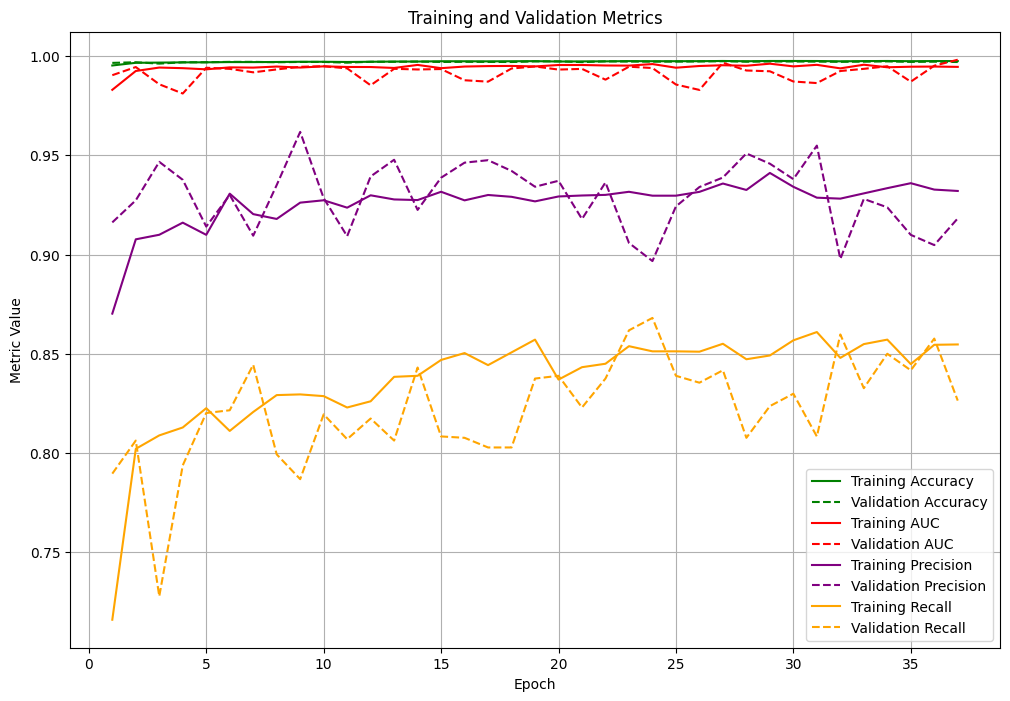

In [32]:

# Get the number of epochs
epochs = range(1, len(history.history['loss']) + 1)

# Define colors and line styles for each metric
colors = ['blue', 'green', 'red', 'purple', 'orange']
line_styles = {
    'train': '-',    # Solid line for training data
    'val': '--'      # Dashed line for validation data
}

# Create the figure and subplots
plt.figure(figsize=(12, 8))

# Training Accuracy
plt.plot(epochs, history.history['accuracy'],
          color=colors[1], linestyle=line_styles['train'],
          label='Training Accuracy')
# Validation Accuracy
plt.plot(epochs, history.history['val_accuracy'],
          color=colors[1], linestyle=line_styles['val'],
          label='Validation Accuracy')

# Training AUC
plt.plot(epochs, history.history['auc'],  # Use 'auc' or the actual key
          color=colors[2], linestyle=line_styles['train'],
          label='Training AUC')
# Validation AUC
plt.plot(epochs, history.history['val_auc'],  # Use 'val_auc' or the actual key
          color=colors[2], linestyle=line_styles['val'],
          label='Validation AUC')

# Training Precision
plt.plot(epochs, history.history['precision'],
          color=colors[3], linestyle=line_styles['train'],
          label='Training Precision')
# Validation Precision
plt.plot(epochs, history.history['val_precision'],
          color=colors[3], linestyle=line_styles['val'],
          label='Validation Precision')

# Training Recall
plt.plot(epochs, history.history['recall'],
          color=colors[4], linestyle=line_styles['train'],
          label='Training Recall')
# Validation Recall
plt.plot(epochs, history.history['val_recall'],
          color=colors[4], linestyle=line_styles['val'],
          label='Validation Recall')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics')
plt.legend()  # Display the legend to identify the lines
plt.grid(True) # Add grid for better readability
plt.show()

# Example usage (replace with your actual history object)
# Assuming 'history' is the object returned by model.fit()
# plot_all_metrics(history)

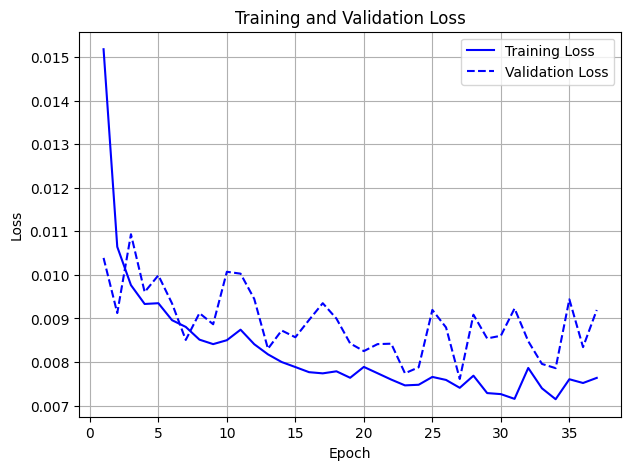

In [33]:
fig = plt.figure(figsize=(7, 5))
plt.plot(epochs, history.history['loss'],
          color=colors[0], linestyle=line_styles['train'],
          label='Training Loss')
# Validation Loss
plt.plot(epochs, history.history['val_loss'],
          color=colors[0], linestyle=line_styles['val'],
          label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()  # Display the legend to identify the lines
plt.grid(True) # Add grid for better readability
plt.show()